# ARoF DPD-NN: Performance

In [2]:
import sys

project_path = r"C:\Users\PC\Documents\Mestrado"
file_path    = project_path + r"\DPD"
sys.path.append(project_path)

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.constants               import pi
from scipy.signal                  import firwin, welch
from tqdm.notebook                 import tqdm
from tabulate                      import tabulate

from optic_private.comm.metrics    import calcEVM
from optic_private.dsp.core        import lowPassFIR, calcACLR
from optic_private.utils           import parameters, lin2dB, dBm2W

from optic_private.torchModulation import modulateGray, demodulateGray, grayMapping
from optic_private.torchMetrics    import fastBERcalc, calcMI, signal_power, papr
from optic_private.torchDSP        import upsample, firFilter, pnorm, hilbert, decimate, finddelay
from optic_private.torchModels     import mzm, linearFiberChannel, photodiode, powerAmplifier
from optic_private.torchOFDM       import modulateOFDM, demodulateOFDM

import torch as th
from torch import nn
from torch.utils.data import Dataset, DataLoader
from optic_private.torchUtils import memoryLessDataSet, MLP, train_model, test_model, slidingWindowDataSet, fitFilterNN

from DPD_utils.NN_tools import NN_training
from DPD_utils.MP_tools import calcSNR_per_carrier
from DPD_utils.plots    import plotDPD_const, plotDPD_spec, plotDPD_SNR

#import logging as logg
#logg.basicConfig(level=logg.WARN, format='%(message)s', force=True)

In [ ]:
font = {'size':14}
plt.rc('font', **font)
plt.rcParams["font.family"] = "serif"

In [36]:
def RoF_channel(sigTx, Rs, SpS, Fs, paramMZM, paramChannel, paramRF, paramPD):
    
    # Sinal RF
    t = th.arange(0, len(sigTx), dtype=th.float64, device=device)*1/Fs
    sigTx_RF = th.real( sigTx * th.exp(1j*2*pi*paramRF.fc_e*t) )
    sigTx_RF = np.sqrt(dBm2W(paramRF.Pin_RF))*pnorm(sigTx_RF)

    # Sonal óptico
    Ai     = np.sqrt(dBm2W(paramMZM.Pin_OF))*th.ones(sigTx_RF.shape, device=device)
    sigTxo = mzm(Ai, sigTx_RF, paramMZM)
    
    numtaps = 4096
    hopt_tx = th.tensor(firwin(numtaps, paramRF.fc_e + 2*Rs, fs = Fs)).to(device)
    sigTxo  = th.sqrt(signal_power(sigTxo))*pnorm(firFilter(sigTxo, hopt_tx))
    
    sigRxo = linearFiberChannel(sigTxo, paramChannel)

    # Sinal elétrico (fotocorrente) 
    I_Rx = photodiode(sigRxo, paramPD)
    I_Rx = pnorm(I_Rx)
    I_Rx -= I_Rx.mean()
    
    # Sinal elétrico pós-FPF
    f1 = paramRF.fc_e - 2*Rs
    f2 = paramRF.fc_e + 2*Rs
    hbp_RF = firwin(numtaps, (f1, f2), pass_zero = 'bandpass', fs = Fs)

    I_RF = firFilter(hbp_RF, I_Rx)

    # Sinal elétrico pós-PA
    sigRx = hilbert(I_RF)*th.exp(-1j*2*pi*paramRF.fc_e*t)
    sigRx = np.sqrt(dBm2W(paramRF.Pin_PA))*pnorm(sigRx)
    sigRx = powerAmplifier(sigRx)
    
    sigRx_PA = sigRx.clone().detach()
    
    hlp = firwin(numtaps, Rs/1.5, fs = Fs)
    sigRx = firFilter(hlp, sigRx)

    # Correção do delay
    delay = finddelay(sigRx, sigTx)
    sigRx = th.roll(sigRx, -delay)
    
    rot = th.mean(sigTx/sigRx)
    sigRx = rot/th.abs(rot)*sigRx
    
    # Parâmetros da decimação
    paramDec = parameters()
    paramDec.SpS_in  = SpS
    paramDec.SpS_out = 1
    
    symbRx_OFDM = decimate(sigRx, paramDec).ravel()
    symbRx = demodulateOFDM(symbRx_OFDM, paramOFDM)

    return sigRx_PA, symbRx

### 1 - Geração do Sinal OFDM

In [40]:
device = 'cuda'
includeMemory = True

# Parâmetros de modulação
modOrder = 64
modType  = 'qam'
Rb = 5e9    
SpS = 64

# OFDM signal parameters
paramOFDM = parameters()
paramOFDM.Nfft = 1024
paramOFDM.Np   = 64
paramOFDM.G    = 32
paramOFDM.hermitSymmetry = False
paramOFDM.SpS = SpS
paramOFDM.pilotCarriers = np.linspace(0, paramOFDM.Nfft-1, paramOFDM.Np, dtype=np.int64) # Pilot subcarriers
Ns = paramOFDM.Nfft - paramOFDM.Np     # Núm. de subportadoras de informação

Rs = Rb / ( Ns/(paramOFDM.Nfft + paramOFDM.G) * np.log2(modOrder) )    # Taxa de transmissão de símbolos
Fs = Rs * SpS                                                          # Taxa de amostragem

# Geração dos bits e dos símbolos QAM
batchSize = 1000//(int(paramOFDM.Nfft/128))
bits = th.randint(2, size = (batchSize*(Ns - 1), int(np.log2(modOrder))), dtype = th.float32, device = device)

symbTx  = modulateGray(bits.view(-1,).type(th.int64), modOrder, modType)    
symbTx  = pnorm(symbTx)

pilotSymb = 0.25*(max(symbTx.real) + 1j*max(symbTx.imag))
paramOFDM.pilot = pilotSymb

In [41]:
sigTx = modulateOFDM(symbTx, paramOFDM)
sigTx = pnorm(sigTx)

t = th.arange(0, len(sigTx), dtype=th.float64, device=device)*1/Fs
t_CP   = SpS * paramOFDM.G * (1/Fs)
t_symb = SpS * (paramOFDM.Nfft + paramOFDM.G) * (1/Fs)

In [42]:
table = [['Grandeza', 'Parâmetro', 'Valor'],
         ['Taxa de amostragem', 'Fs', f'{Fs*1e-9:.2f} Gsamples/s'],
         ['Taxa de símbolos', 'Rs', f'{Rs*1e-9:.2f} Gsymb/s'],
         ['Taxa de transmissão', 'Rb', f'{Rb*1e-9:.2f} Gb/s'],
         ['Ordem da constelação', 'M', f'{modOrder}'],
         ['Tamanho da FFT', 'Nfft', f'{paramOFDM.Nfft}'],
         ['Tamanho do prefixo cíclico', 'G', f'{paramOFDM.G}'],
         ['Num. port. de informação', 'Ns', f'{Ns}'],
         ['Num. port. piloto', 'Np', f'{paramOFDM.Np}'],
         ['Espaçamento entre subportadoras', 'Delta_f', f'{(Rs/paramOFDM.Nfft)*1e-6:.2f} MHz'],
         ['Duração do símbolo OFDM', 'T_symb', f'{1e9*t_symb:.2f} ns'],
         ['Duração do prefixo cíclico', 'T_CP', f'{1e9*t_CP:.2f} ns'] ]

print(tabulate(table, headers = 'firstrow', tablefmt = 'fancy_grid'))

╒═════════════════════════════════╤═════════════╤══════════════════╕
│ Grandeza                        │ Parâmetro   │ Valor            │
╞═════════════════════════════════╪═════════════╪══════════════════╡
│ Taxa de amostragem              │ Fs          │ 58.67 Gsamples/s │
├─────────────────────────────────┼─────────────┼──────────────────┤
│ Taxa de símbolos                │ Rs          │ 0.92 Gsymb/s     │
├─────────────────────────────────┼─────────────┼──────────────────┤
│ Taxa de transmissão             │ Rb          │ 5.00 Gb/s        │
├─────────────────────────────────┼─────────────┼──────────────────┤
│ Ordem da constelação            │ M           │ 64               │
├─────────────────────────────────┼─────────────┼──────────────────┤
│ Tamanho da FFT                  │ Nfft        │ 1024             │
├─────────────────────────────────┼─────────────┼──────────────────┤
│ Tamanho do prefixo cíclico      │ G           │ 32               │
├─────────────────────────────────

In [43]:
## Parametrização dos dispositivos

# Parâmetros do MZM
paramMZM = parameters()
paramMZM.Vpi = 3
paramMZM.Vb = -paramMZM.Vpi/2
paramMZM.Pin_OF = 15

# Parâmetros do canal óptico
paramChannel = parameters()
paramChannel.L = 30
paramChannel.alpha = 0.2
paramChannel.D = 16
paramChannel.Fc = 193.1e12
paramChannel.Fs = Fs

#
paramRF = parameters()
paramRF.fc_e = 5e9
paramRF.Pin_RF = 17
paramRF.Pin_PA = 5

# Parâmetros do fotodiodo
paramPD = parameters()
paramPD.ideal = False
paramPD.B = paramRF.fc_e + 2*Rs
paramPD.Ipd_sat = 50e-3
paramPD.Fs = Fs

#### Training Sweep

In [44]:
powerRF_sweep   = np.arange( 10, 26, 1)
powerInPA_sweep = np.arange(-10, 11, 1)

In [45]:
SpS_nn = 4
N = 150000

paramDec = parameters()
paramDec.SpS_in = SpS
paramDec.SpS_out = SpS_nn

#
paramTrain = parameters()

paramTrain.N1 = 16
paramTrain.N2 = 8

paramTrain.divByL = 25
paramTrain.trainTestFrac = 0.75
paramTrain.batch_size = 100
paramTrain.shuffle = False
paramTrain.includeMemory = includeMemory
paramTrain.Ntaps = 8

paramTrain.device = device
paramTrain.lr = 10e-3
paramTrain.epochs = 500
paramTrain.pgrsBar = False

paramTrain.num_feat = 2
paramTrain.directLearn = False
paramTrain.augment = False

In [ ]:

for i, inPowerPA in enumerate(tqdm(powerInPA_sweep)):
    
    for j, inPowerRF in enumerate(powerRF_sweep):
        
        paramRF.Pin_RF = inPowerRF
        paramRF.Pin_PA = inPowerPA

        sigRx_PA, symbRx = RoF_channel(sigTx, Rs, SpS, Fs, paramMZM, paramChannel, paramRF, paramPD)
        
        # Decimação para o sinal de treinamento
        hlp = firwin(4096, SpS_nn*Rs/2, fs = Fs)

        sigRef = decimate(pnorm(firFilter(hlp, sigTx)), paramDec)
        sigIn  = decimate(pnorm(firFilter(hlp, sigRx_PA)), paramDec).type(th.complex64)
        
        sigRef = pnorm(sigRef).flatten()
        sigIn  = pnorm(sigIn).flatten()

        # Correção de atrasos
        delay = finddelay(sigIn, sigRef)
        sigIn = th.roll(sigIn, -delay)
        
        rot = th.mean(sigRef/sigIn)
        sigIn = rot/th.abs(rot)*sigIn

        # Cálculo do modelo para identificação do canal
        paramTrain.num_feat = 2
        paramTrain.directLearn = False
        paramTrain.augment = False
        
        RoFChannel_model, _, _ = NN_training(sigRef[0:N], sigIn[0:N], paramTrain)

        # Aprendizado indireto
        paramTrain.num_feat = 5
        paramTrain.directLearn = False
        paramTrain.augment = True

        DPD_indirectLearn, _, _ = NN_training(sigIn[0:N], sigRef[0:N], paramTrain)
        
        # Aprendizado direto
        paramTrain.num_feat = 5
        paramTrain.directLearn = True
        paramTrain.augment = True
        
        DPD_directLearn, trainLoss, testLoss = NN_training(sigIn[0:N], sigRef[0:N], paramTrain, RoFChannel_model)
        
        # Saving models
        th.save(RoFChannel_model.state_dict(), 
                file_path + f'\\Models_NN\\RoFChannel_f_{paramRF.fc_e/1e9:.1f}GHz_PowerPA_{inPowerPA}dB_PowerRF_{inPowerRF}dB.pth')

        th.save(DPD_indirectLearn.state_dict(), 
                file_path + f'\\Models_NN\\DPD_indirectLearn_f_{paramRF.fc_e/1e9:.1f}GHz_PowerPA_{inPowerPA}dB_PowerRF_{inPowerRF}dB.pth')

        th.save(DPD_directLearn.state_dict(), 
                file_path + f'\\Models_NN\\DPD_directLearn_f_{paramRF.fc_e/1e9:.1f}GHz_PowerPA_{inPowerPA}dB_PowerRF_{inPowerRF}dB.pth')


# 5952 s/it

#### Test Sweep

In [55]:
# OFDM signal parameters
paramOFDM = parameters()
paramOFDM.Nfft = 1024
paramOFDM.Np   = 64
paramOFDM.G    = 32
paramOFDM.hermitSymmetry = False
paramOFDM.SpS = SpS_nn
paramOFDM.pilotCarriers = np.linspace(0, paramOFDM.Nfft-1, paramOFDM.Np, dtype=np.int64) # Pilot subcarriers
Ns = paramOFDM.Nfft - paramOFDM.Np     # Núm. de subportadoras de informação

Rs = Rb / ( Ns/(paramOFDM.Nfft + paramOFDM.G) * np.log2(modOrder) )    # Taxa de transmissão de símbolos
Fs = Rs * SpS                                                          # Taxa de amostragem

# Geração dos bits e dos símbolos QAM
batchSize = 1000//(int(paramOFDM.Nfft/128))
bits = th.randint(2, size = (batchSize*(Ns - 1), int(np.log2(modOrder))), dtype = th.float32, device = device)

symbTx = modulateGray(bits.view(-1,).type(th.int64), modOrder, modType)    
symbTx = pnorm(symbTx)

pilotSymb = 0.25*(max(symbTx.real) + 1j*max(symbTx.imag))
paramOFDM.pilot = pilotSymb

sigTx = modulateOFDM(symbTx, paramOFDM)
sigTx = pnorm(sigTx)

In [60]:
discard = 500
index = th.arange(discard, len(symbTx) - discard)

EVM_woDPD = np.zeros((powerInPA_sweep.size, powerRF_sweep.size))
EVM_DLA   = np.zeros(EVM_woDPD.shape)
EVM_ILA   = np.zeros(EVM_woDPD.shape)

ACLR_woDPD = np.zeros(EVM_woDPD.shape)
ACLR_DLA   = np.zeros(EVM_woDPD.shape)
ACLR_ILA   = np.zeros(EVM_woDPD.shape)

SNR_woDPD = np.zeros(EVM_woDPD.shape)
SNR_DLA   = np.zeros(EVM_woDPD.shape)
SNR_ILA   = np.zeros(EVM_woDPD.shape)

In [61]:
h_dpd = th.tensor(firwin(4096, 2*Rs, fs = Fs)).to(device)

for i, inPowerPA in enumerate(tqdm(powerInPA_sweep)):
    for j, inPowerRF in enumerate(powerRF_sweep):
        paramRF.Pin_RF = inPowerRF
        paramRF.Pin_PA = inPowerPA
        
        # carregar os modelos
        DPD_directLearn = MLP([paramTrain.num_input*paramTrain.Ntaps, paramTrain.N1, paramTrain.N2, 2], activation=nn.ReLU()).to(device)
        DPD_directLearn.load_state_dict(th.load(file_path + f'\\Models_NN\\DPD_directLearn_f_{paramRF.fc_e/1e9:.1f}GHz_PowerPA_{inPowerPA}dB_PowerRF_{inPowerRF}dB.pth', weights_only = True))
        
        DPD_indirectLearn = MLP([paramTrain.num_input*paramTrain.Ntaps, paramTrain.N1, paramTrain.N2, 2], activation=nn.ReLU()).to(device)
        DPD_indirectLearn.load_state_dict(th.load(file_path + f'\\Models_NN\\DPD_indirectLearn_f_{paramRF.fc_e/1e9:.1f}GHz_PowerPA_{inPowerPA}dB_PowerRF_{inPowerRF}dB.pth', weights_only = True))    

        # DLA
        DPD_directLearn.eval()
        if includeMemory:
            sigTx_DLA = fitFilterNN(sigTx, DPD_directLearn, paramTrain.Ntaps, 1, 4000, augment = paramTrain.augment)
        else:
            with th.no_grad():
                sigTx_DLA = th.view_as_complex(DPD_directLearn(th.view_as_real(sigTx)))
        
        # ILA
        DPD_indirectLearn.eval()
        if includeMemory:
            sigTx_ILA = fitFilterNN(sigTx, DPD_indirectLearn, paramTrain.Ntaps, 1, 4000, augment = paramTrain.augment)
        else:
            with th.no_grad():
                sigTx_ILA = th.view_as_complex(DPD_indirectLearn(th.view_as_real(sigTx)))
        
        
        # Upsampling
        sigTx_woDPD = upsample(sigTx.reshape(-1,1), SpS//SpS_nn).reshape(-1,) 
        sigTx_woDPD = firFilter(sigTx_woDPD, h_dpd)
        
        # ILA
        sigTx_ILA = upsample(sigTx_ILA.reshape(-1,1), SpS//SpS_nn).reshape(-1,) 
        sigTx_ILA = firFilter(sigTx_ILA, h_dpd)
        
        # DLA
        sigTx_DLA = upsample(sigTx_DLA.reshape(-1,1), SpS//SpS_nn).reshape(-1,) 
        sigTx_DLA = firFilter(sigTx_DLA, h_dpd)

        sigRx_PA, symbRx = RoF_channel(sigTx_woDPD, Rs, SpS, Fs, paramMZM, paramChannel, paramRF, paramPD)
        sigRx_PA_DLA, symbRx_DLA = RoF_channel(sigTx_DLA, Rs, SpS, Fs, paramMZM, paramChannel, paramRF, paramPD)
        sigRx_PA_ILA, symbRx_ILA = RoF_channel(sigTx_ILA, Rs, SpS, Fs, paramMZM, paramChannel, paramRF, paramPD)

        symbRx = pnorm(symbRx)
        symbRx_DLA = pnorm(symbRx_DLA)
        symbRx_ILA = pnorm(symbRx_ILA)
        
        # Metrics
        freq, P_sigTx            = welch(pnorm(sigTx_woDPD).detach().cpu().numpy()[0::SpS//SpS_nn], fs = SpS_nn*Rs, nfft = 16*1024, return_onesided = False)
        freq, P_sigRx_PA         = welch(pnorm(sigRx_PA).detach().cpu().numpy()[0::SpS//SpS_nn], fs = SpS_nn*Rs, nfft = 16*1024, return_onesided = False)
        freq_DLA, P_sigRx_PA_DLA = welch(pnorm(sigRx_PA_DLA).detach().cpu().numpy()[0::SpS//SpS_nn], fs = SpS_nn*Rs, nfft = 16*1024, return_onesided = False)
        freq_ILA, P_sigRx_PA_ILA = welch(pnorm(sigRx_PA_ILA).detach().cpu().numpy()[0::SpS//SpS_nn], fs = SpS_nn*Rs, nfft = 16*1024, return_onesided = False)
        
        ACLR_woDPD[i, j] = calcACLR(P_sigRx_PA, freq, 0.5e9)
        ACLR_DLA[i, j]   = calcACLR(P_sigRx_PA_DLA, freq_DLA, 0.5e9)
        ACLR_ILA[i, j]   = calcACLR(P_sigRx_PA_ILA, freq_ILA, 0.5e9)
        
        _, _, SNR_woDPD[i, j] = fastBERcalc(symbRx[index],     symbTx[index], modOrder, modType)
        _, _, SNR_DLA[i, j]   = fastBERcalc(symbRx_DLA[index], symbTx[index], modOrder, modType)
        _, _, SNR_ILA[i, j]   = fastBERcalc(symbRx_ILA[index], symbTx[index], modOrder, modType)

        EVM_woDPD[i, j] = 10*np.log10(calcEVM(symbRx.detach().cpu().numpy(),     modOrder, modType))[0]
        EVM_DLA[i, j]   = 10*np.log10(calcEVM(symbRx_DLA.detach().cpu().numpy(), modOrder, modType))[0]
        EVM_ILA[i, j]   = 10*np.log10(calcEVM(symbRx_ILA.detach().cpu().numpy(), modOrder, modType))[0]

        # Plots
        # Constellation
        plotDPD_const(symbTx.detach().cpu().numpy(), symbRx.detach().cpu().numpy(), symbRx_DLA.detach().cpu().numpy(), symbRx_ILA.detach().cpu().numpy(), show = False, savefig = True, 
                     file_path = file_path + f"\\Plots_NN\\Constellation_plots\\Const_f_{paramRF.fc_e/1e9:.1f}GHz_PowerPA_{inPowerPA}dB_PowerRF_{inPowerRF}dB.pdf")

        # Spectrum
        plotDPD_spec(freq, P_sigTx, P_sigRx_PA, P_sigRx_PA_DLA, P_sigRx_PA_ILA, Rs, show = False, savefig = True, 
                    file_path = file_path + f"\\Plots_NN\\Spectrum_plots\\Spectrum_f_{paramRF.fc_e/1e9:.1f}GHz_PowerPA_{inPowerPA}dB_PowerRF_{inPowerRF}dB.pdf")
        
        # SNR per carrier
        SNR_per_carrier_woDPD = calcSNR_per_carrier(symbTx.detach().cpu().numpy(), symbRx.detach().cpu().numpy(), Ns-1)
        SNR_per_carrier_DLA   = calcSNR_per_carrier(symbTx.detach().cpu().numpy(), symbRx_DLA.detach().cpu().numpy(), Ns-1)
        SNR_per_carrier_ILA   = calcSNR_per_carrier(symbTx.detach().cpu().numpy(), symbRx_ILA.detach().cpu().numpy(), Ns-1)
        
        plotDPD_SNR(SNR_per_carrier_woDPD, SNR_per_carrier_DLA, Ns, "DLA", show = False, savefig = True, 
                    file_path = file_path + f"\\Plots_NN\\SNR_per_carriers_plots\\SNR_DLA_f_{paramRF.fc_e/1e9:.1f}GHz_PowerPA_{inPowerPA}dB_PowerRF_{inPowerRF}dB.pdf")
        
        plotDPD_SNR(SNR_per_carrier_woDPD, SNR_per_carrier_ILA, Ns, "ILA", show = False, savefig = True, 
                    file_path = file_path + f"\\Plots_NN\\SNR_per_carriers_plots\\SNR_ILA_f_{paramRF.fc_e/1e9:.1f}GHz_PowerPA_{inPowerPA}dB_PowerRF_{inPowerRF}dB.pdf")


# save metrics arrays...
np.savetxt(file_path + f'\\Metrics_NN\\EVM_woDPD_f_{paramRF.fc_e/1e9:.1f}GHz.txt', EVM_woDPD, fmt = '%f')
np.savetxt(file_path + f'\\Metrics_NN\\EVM_DLA_f_{paramRF.fc_e/1e9:.1f}GHz.txt', EVM_DLA, fmt = '%f')
np.savetxt(file_path + f'\\Metrics_NN\\EVM_ILA_f_{paramRF.fc_e/1e9:.1f}GHz.txt', EVM_ILA, fmt = '%f')

np.savetxt(file_path + f'\\Metrics_NN\\ACLR_woDPD_f_{paramRF.fc_e/1e9:.1f}GHz.txt', ACLR_woDPD, fmt = '%f')
np.savetxt(file_path + f'\\Metrics_NN\\ACLR_DLA_f_{paramRF.fc_e/1e9:.1f}GHz.txt', ACLR_DLA, fmt = '%f')
np.savetxt(file_path + f'\\Metrics_NN\\ACLR_ILA_f_{paramRF.fc_e/1e9:.1f}GHz.txt', ACLR_ILA, fmt = '%f')

np.savetxt(file_path + f'\\Metrics_NN\\SNR_woDPD_f_{paramRF.fc_e/1e9:.1f}GHz.txt', SNR_woDPD, fmt = '%f')
np.savetxt(file_path + f'\\Metrics_NN\\SNR_DLA_f_{paramRF.fc_e/1e9:.1f}GHz.txt', SNR_DLA, fmt = '%f')
np.savetxt(file_path + f'\\Metrics_NN\\SNR_ILA_f_{paramRF.fc_e/1e9:.1f}GHz.txt', SNR_ILA, fmt = '%f')

  0%|          | 0/21 [00:00<?, ?it/s]

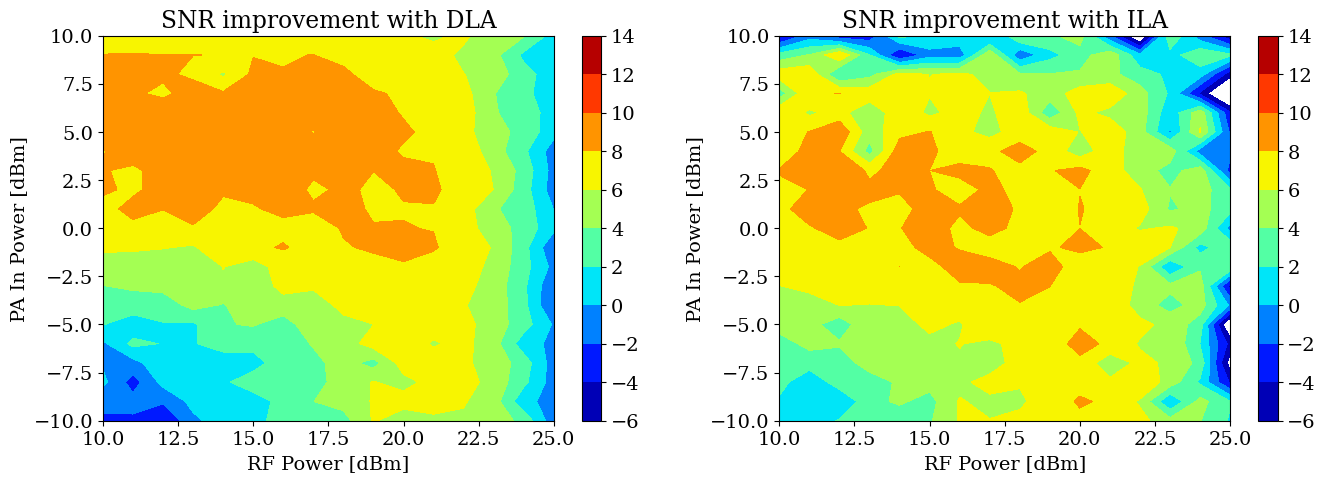

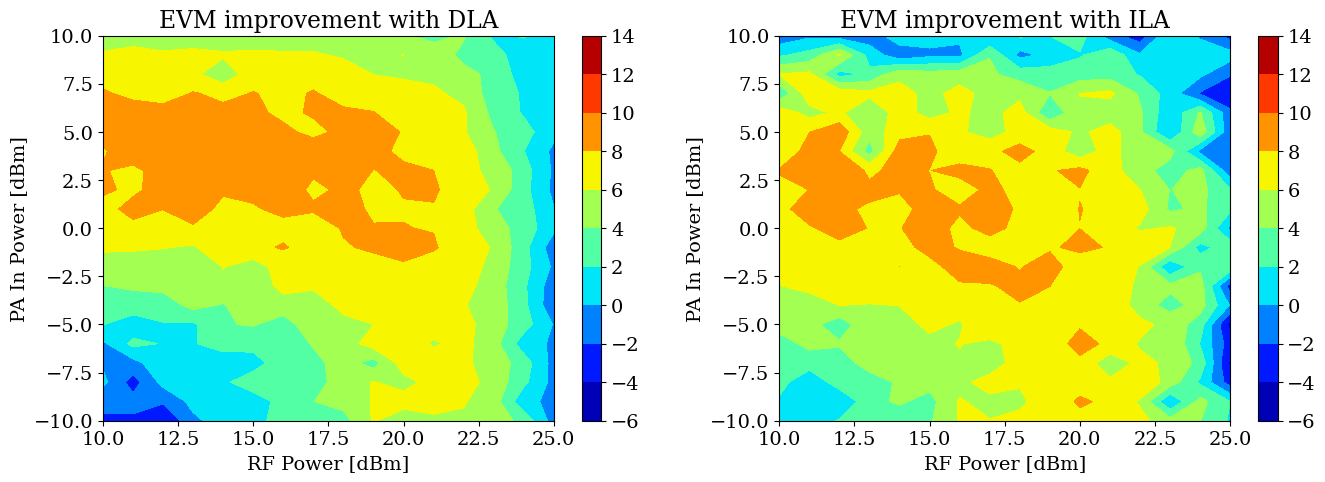

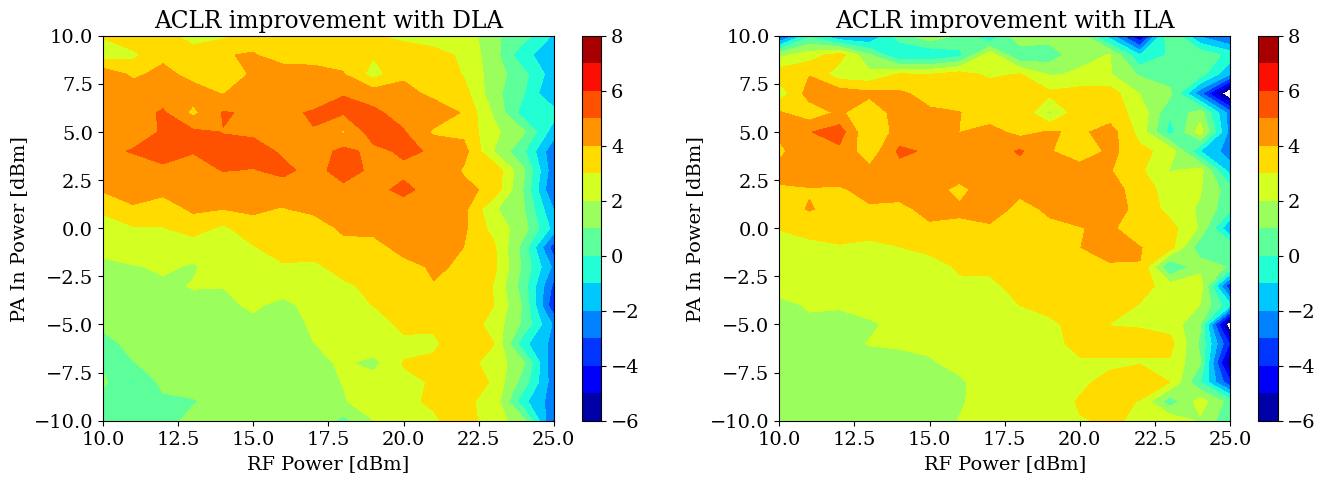

In [71]:
X, Y = np.meshgrid(powerRF_sweep, powerInPA_sweep)

# SNR
fig, axs = plt.subplots(1, 2, figsize = (16, 5))
Z1 = SNR_DLA - SNR_woDPD
Z2 = SNR_ILA - SNR_woDPD
#cbarticks = np.arange(np.floor(Z1.min()) - 2, np.ceil(Z2.max()) + 0.5, 0.5)
cbarticks = np.arange(-6, 15, 2)

snr_dla_plt = axs[0].contourf(X, Y, Z1, cbarticks, cmap = 'jet')
axs[0].set_title('SNR improvement with DLA')
axs[0].set_ylabel('PA In Power [dBm]')
axs[0].set_xlabel('RF Power [dBm]')
plt.colorbar(snr_dla_plt, ax = axs[0], ticks = cbarticks)

snr_ila_plt = axs[1].contourf(X, Y, Z2, cbarticks, cmap = 'jet')
axs[1].set_title('SNR improvement with ILA')
axs[1].set_ylabel('PA In Power [dBm]')
axs[1].set_xlabel('RF Power [dBm]')
plt.colorbar(snr_ila_plt, ax = axs[1], ticks = cbarticks)

# EVM
fig, axs = plt.subplots(1, 2, figsize = (16, 5))
Z1 = EVM_woDPD - EVM_DLA
Z2 = EVM_woDPD - EVM_ILA
#cbarticks = np.arange(np.floor(Z1.min()) - 2, np.ceil(Z2.max()) + 0.5, 0.5)
cbarticks = np.arange(-6, 15, 2)

evm_dla_plt = axs[0].contourf(X, Y, Z1, cbarticks, cmap = 'jet', antialiased = False)
axs[0].set_title('EVM improvement with DLA')
axs[0].set_ylabel('PA In Power [dBm]')
axs[0].set_xlabel('RF Power [dBm]')
plt.colorbar(evm_dla_plt, ax = axs[0], ticks = cbarticks)

evm_ila_plt = axs[1].contourf(X, Y, Z2, cbarticks, cmap = 'jet', antialiased = False)
axs[1].set_title('EVM improvement with ILA')
axs[1].set_ylabel('PA In Power [dBm]')
axs[1].set_xlabel('RF Power [dBm]')
plt.colorbar(evm_ila_plt, ax = axs[1], ticks = cbarticks)

# ACLR
fig, axs = plt.subplots(1, 2, figsize = (16, 5))
Z1 = ACLR_woDPD - ACLR_DLA
Z2 = ACLR_woDPD - ACLR_ILA
cbarticks = np.arange(np.floor(Z1.min()) - 3, np.ceil(Z2.max()) + 0.25, 0.25)
cbarticks = np.arange(-6, 9, 1)

aclr_dla_plt = axs[0].contourf(X, Y, Z1, cbarticks, cmap = 'jet', antialiased = False)
axs[0].set_title('ACLR improvement with DLA')
axs[0].set_ylabel('PA In Power [dBm]')
axs[0].set_xlabel('RF Power [dBm]')
plt.colorbar(aclr_dla_plt, ax = axs[0], ticks = cbarticks[::2])

aclr_ila_plt = axs[1].contourf(X, Y, Z2, cbarticks, cmap = 'jet', antialiased=False)
axs[1].set_title('ACLR improvement with ILA')
axs[1].set_ylabel('PA In Power [dBm]')
axs[1].set_xlabel('RF Power [dBm]')
plt.colorbar(aclr_ila_plt, ax = axs[1], ticks = cbarticks[::2])